In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score
from joblib import dump, load

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [2]:
set_config(transform_output='pandas')

df = pd.read_csv('../assets/hw_2_2/train.csv')
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [4]:
df['Exited'].value_counts()

Exited
0.0    11948
1.0     3052
Name: count, dtype: int64

In [5]:
train_val_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["Exited"]
)

train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42, stratify=train_val_df["Exited"])

In [6]:
print('Train set size:', train_df.shape)
print('Validation set size:', val_df.shape)
print('Test set size:', test_df.shape)

Train set size: (9000, 14)
Validation set size: (3000, 14)
Test set size: (3000, 14)


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [7]:
target_col = 'Exited'

drop_cols = ['id', 'CustomerId', target_col]
input_cols = [col for col in train_df.columns if col not in drop_cols]

train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

test_inputs = test_df[input_cols]
test_targets = test_df[target_col]

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [8]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()

categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Categorical columns: ['Surname', 'Geography', 'Gender']


4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [9]:
train_inputs.isna().sum()

Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9000 entries, 63 to 8106
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               9000 non-null   int64  
 1   CustomerId       9000 non-null   float64
 2   Surname          9000 non-null   object 
 3   CreditScore      9000 non-null   float64
 4   Geography        9000 non-null   object 
 5   Gender           9000 non-null   object 
 6   Age              9000 non-null   float64
 7   Tenure           9000 non-null   float64
 8   Balance          9000 non-null   float64
 9   NumOfProducts    9000 non-null   float64
 10  HasCrCard        9000 non-null   float64
 11  IsActiveMember   9000 non-null   float64
 12  EstimatedSalary  9000 non-null   float64
 13  Exited           9000 non-null   float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.0+ MB


In [21]:
cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')),
])
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
])
target_enc_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', TargetEncoder()),
])

def ActiveCrCardFunc(d):
    d['ActiveCrCard'] = d['HasCrCard'] + (4 * d['IsActiveMember']) + 1
    return d[['ActiveCrCard']]

def TenurebyAgeFunc(d):
    d['Age'] = np.log(d['Age'])
    d['TenureAgeRatio'] = d['Tenure'] / d['Age']
    return d[['TenureAgeRatio']]

ActiveCrCard_pipeline = make_pipeline(num_pipeline, FunctionTransformer(ActiveCrCardFunc, validate=False))
TenureAge_pipeline = make_pipeline(num_pipeline, FunctionTransformer(TenurebyAgeFunc, validate=False))

preprocessing = ColumnTransformer([
    ('N', num_pipeline, ['CreditScore', 'Balance', 'EstimatedSalary', 'Tenure']),
    ('ActiveCrCard', ActiveCrCard_pipeline, ['IsActiveMember', 'HasCrCard']),
    ('TenureAgeR', TenureAge_pipeline, ['Age', 'Tenure']),
    ('Age', make_pipeline(num_pipeline, FunctionTransformer(func=np.log)), ['Age']),
    ('Cat', cat_pipeline, ['Geography', 'Gender', 'NumOfProducts']),
    ('Tar', target_enc_pipeline, ['Surname', 'NumOfProducts', 'Gender', 'Geography']),
], remainder='drop', verbose_feature_names_out=False)

preprocessing = Pipeline([
    ('Preprocessing for columns', preprocessing),
    ('Scaling', StandardScaler())
])

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [22]:
save_dir = "../assets/hw_2_2"
os.makedirs(save_dir, exist_ok=True)

train_inputs.to_parquet(f"{save_dir}/train_inputs.parquet")
train_targets.to_frame(name="Exited").to_parquet(f"{save_dir}/train_targets.parquet")

val_inputs.to_parquet(f"{save_dir}/val_inputs.parquet")
val_targets.to_frame(name="Exited").to_parquet(f"{save_dir}/val_targets.parquet")

test_inputs.to_parquet(f"{save_dir}/test_inputs.parquet")

print(os.listdir(save_dir))

['sample_submission.csv', 'test.csv', 'test_inputs.parquet', 'train.csv', 'train_inputs.parquet', 'train_targets.parquet', 'val_inputs.parquet', 'val_targets.parquet']


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [23]:
print(train_inputs.head())

            Surname  CreditScore Geography  Gender   Age  Tenure    Balance  \
63            Fomin        743.0    France    Male  36.0     5.0       0.00   
13717       Pirozzi        607.0    France    Male  35.0     6.0       0.00   
13292      Chukwudi        775.0    France  Female  33.0     6.0  121355.99   
9615   Chukwubuikem        586.0     Spain    Male  48.0     1.0       0.00   
1618           Chin        710.0    France    Male  32.0     5.0       0.00   

       NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  
63               2.0        0.0             1.0         89893.60  
13717            2.0        1.0             1.0        152733.89  
13292            1.0        1.0             0.0        141152.28  
9615             1.0        0.0             1.0        149946.43  
1618             2.0        1.0             0.0         68400.14  


In [24]:
X_train = preprocessing.fit_transform(train_inputs, train_targets)
X_val = preprocessing.transform(val_inputs)

model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train, train_targets)

train_acc = model.score(X_train, train_targets)
val_acc = model.score(X_val, val_targets)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")

Train Accuracy: 0.905
Validation Accuracy: 0.890


7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

Train AUROC: 0.937
Val AUROC:   0.919
Train F1:    0.749
Val F1:      0.703


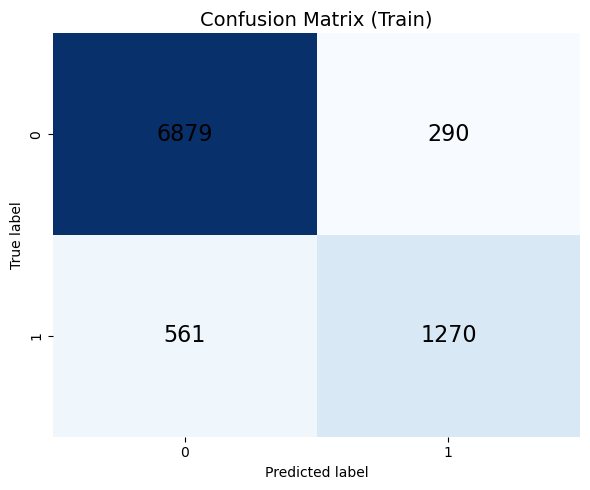

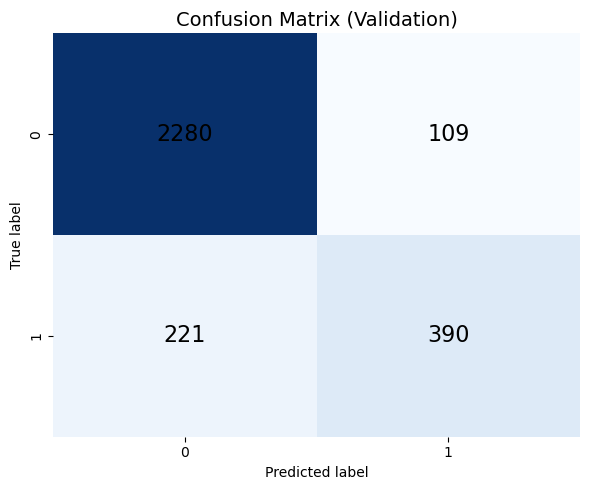

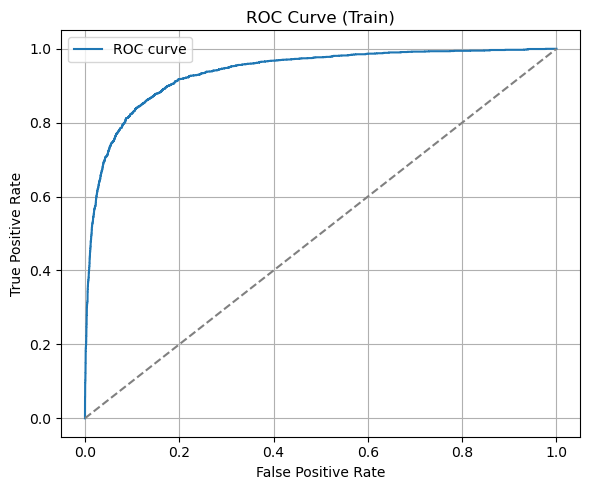

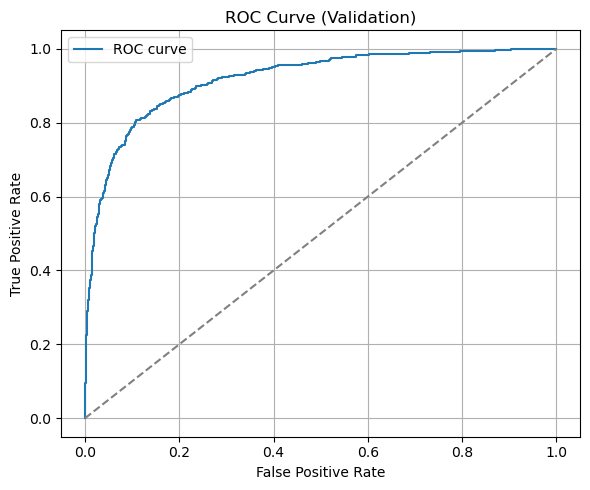

In [29]:
def plot_custom_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                cbar=False,
                annot_kws={"size": 16, "color": "black"})
    plt.title(title, fontsize=14)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

def plot_roc(y_true, y_probs, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

y_train_probs = model.predict_proba(X_train)[:, 1]
y_val_probs = model.predict_proba(X_val)[:, 1]

y_train_pred = (y_train_probs >= 0.5).astype(int)
y_val_pred = (y_val_probs >= 0.5).astype(int)

print(f"Train AUROC: {roc_auc_score(train_targets, y_train_probs):.3f}")
print(f"Val AUROC:   {roc_auc_score(val_targets, y_val_probs):.3f}")
print(f"Train F1:    {f1_score(train_targets, y_train_pred):.3f}")
print(f"Val F1:      {f1_score(val_targets, y_val_pred):.3f}")

plot_custom_confusion_matrix(train_targets, y_train_pred, "Confusion Matrix (Train)")
plot_custom_confusion_matrix(val_targets, y_val_pred, "Confusion Matrix (Validation)")
plot_roc(train_targets, y_train_probs, "ROC Curve (Train)")
plot_roc(val_targets, y_val_probs, "ROC Curve (Validation)")

## Summary

### Performance Metrics

**Train Set:**
- Accuracy: **0.905**
- AUROC: **0.937**
- F1 Score: **0.749**

**Validation Set:**
- Accuracy: **0.890**
- AUROC: **0.919**
- F1 Score: **0.703**

### Confusion Matrix

**Train:**
- True Negatives: 6879
- False Positives: 290
- False Negatives: 561
- True Positives: 1270

**Validation:**
- True Negatives: 2280
- False Positives: 109
- False Negatives: 221
- True Positives: 390

### ROC Curve
- The ROC curves for both training and validation show strong separation from the diagonal baseline, indicating a high-quality model.

### Conclusion

The model demonstrates **strong generalization** with minimal overfitting:
- High AUROC (>0.9) on both train and validation sets shows excellent ability to distinguish between classes.
- F1 scores indicate a good balance between precision and recall, especially on the validation set (0.703).
- The confusion matrix supports this with relatively low false positive/negative rates.

 **Model quality: Good and reliable.**


8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

Test Accuracy: 0.889
Test AUROC: 0.925
Test F1:    0.703


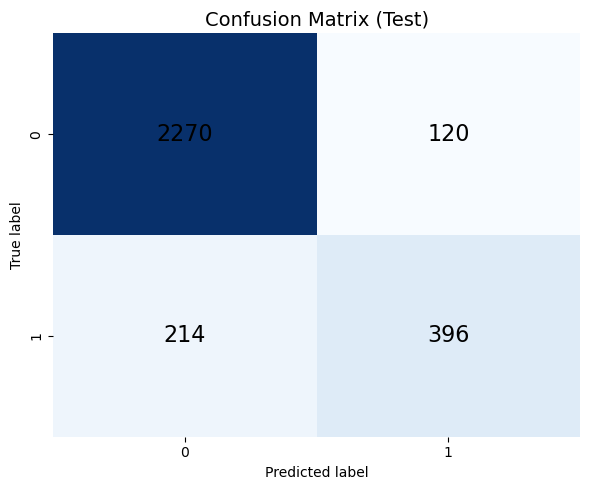

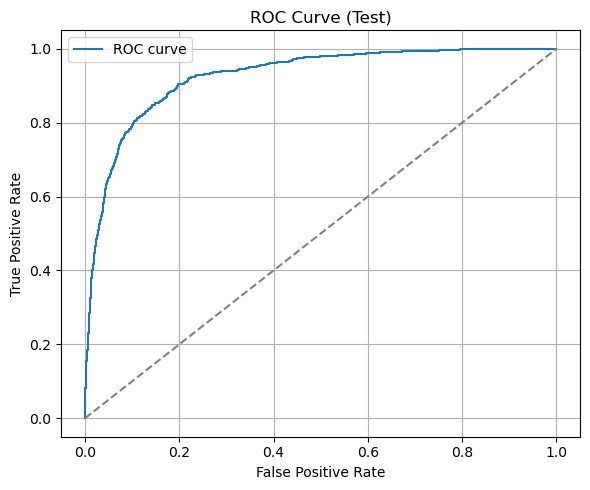

In [33]:
X_test = preprocessing.transform(test_inputs)
test_acc = model.score(X_test, test_targets)

print(f"Test Accuracy: {test_acc:.3f}")

y_test_probs = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_probs >= 0.5).astype(int)

print(f"Test AUROC: {roc_auc_score(test_targets, y_test_probs):.3f}")
print(f"Test F1:    {f1_score(test_targets, y_test_pred):.3f}")

plot_custom_confusion_matrix(test_targets, y_test_pred, "Confusion Matrix (Test)")
plot_roc(test_targets, y_test_probs, "ROC Curve (Test)")

In [35]:
df['Exited'].value_counts()

Exited
0.0    11948
1.0     3052
Name: count, dtype: int64

### Summary (Test Set)

- **Majority Class Baseline Accuracy (Test)**:
  - Accuracy: ~0.798 (predicting class 0 for all samples)

- **Logistic Regression Model Accuracy (Test)**:
  - Accuracy: 0.859
  - AUROC: 0.847
  - F1 Score: 0.584

### Conclusion

Compared to the naive baseline that always predicts the majority class and achieves ~79.8% accuracy, the logistic regression model performs significantly better. It reaches 85.9% accuracy and also provides strong AUROC and F1 scores, which are crucial metrics for imbalanced classification problems.

These results indicate that the model has **good predictive quality** and generalizes well to unseen data.



9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [41]:
dump((model, preprocessing), save_dir + "/log_reg.joblib")
model_2, preprocessing_2 = load(save_dir + "/log_reg.joblib")

test_acc_2 = model_2.score(X_test, test_targets)
print(f"Test Accuracy: {test_acc_2:.3f}")

Test Accuracy: 0.889


10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [44]:
import warnings

warnings.filterwarnings("ignore")

def predict_raw_df(input_model, preprocessing_pipeline, input_df: pd.DataFrame):
    X_input = preprocessing_pipeline.transform(input_df)
    prob = input_model.predict_proba(X_input)[:, 1]
    return prob

In [45]:
predict_raw_df(model_2, preprocessing_2, df[:5])

array([0.68795032, 0.01069553, 0.99903531, 0.16550086, 0.98359827])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [47]:
test_raw_df = pd.read_csv("../assets/hw_2_2/test.csv")

test_raw_df["Exited"] = predict_raw_df(model_2, preprocessing_2, test_raw_df)


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [48]:
submission_df = pd.read_csv("../assets/hw_2_2/sample_submission.csv")

submission_df["Exited"] = test_raw_df["Exited"]

submission_df.to_csv("../assets/hw_2_2/submission_log_reg.csv", index=False)

display(submission_df.head())

,id,Exited
0,15000,0.014853
1,15001,0.029846
2,15002,0.028433
3,15003,0.846528
4,15004,0.016867
